# Introductory Snorkel Tutorial: Spam Detection

* Nice introductory text
* Purpose of this tutorial...
* Steps:
    1. Load data
    2. Write labeling functions (LFs)
    3. Combine with Label Model
    4. Predict with Classifier

### Task: Spam Detection

* Here's what we're trying to do
* Here's where the data came from (cite properly)
* Show sample T and F in markdown

### Data Splits in Snorkel

* 4 splits: train, dev, valid, test
* train is large and unlabeled
* valid/test is labeled and you don't look at it
* best to come up with LFs while looking at data. Options:
    * look at train for ideas; no labels, but np.
    * label small subset of train (e.g., 100), call it "dev"
    * in a pinch, use valid set as dev (note though that valid will no longer be good rep of test)

## 1. Load data

We start by loading our data. 
The `load_spam_dataset()` method downloads the raw csv files from the internet, divides them into splits, converts them into dataframes, and shuffles them.
As mentioned above, the dataset contains comments from 5 of the most popular YouTube videos during a particular timeframe in 2014 and 2015.
* The first four videos' comments are combined to form the `train` set. This set has no gold labels.
* The `dev` set is a random sample of 200 `DataPoints` from the `train` set with gold labels added.
* The fifth video is split 50/50 between a validation set (`valid`) and `test` set.

In [1]:
from utils import load_spam_dataset

df_train, df_dev, df_valid, df_test = load_spam_dataset()

The class distribution varies slightly from class to class, but all are approximately class-balanced.

In [2]:
from collections import Counter

# For clarity, we'll define constants to represent the class labels for spam, ham, and abstaining.
ABSTAIN = 0
SPAM = 1
HAM = 2

for split_name, df in [("train", df_train), ("dev", df_dev), ("valid", df_valid), ("test", df_test)]:
    counts = Counter(df["LABEL"].values)
    print(f"{split_name.upper():<6} {counts[SPAM] * 100/sum(counts.values()):0.1f}% SPAM")

TRAIN  52.4% SPAM
DEV    54.0% SPAM
VALID  47.0% SPAM
TEST   47.0% SPAM


Taking a peek at our data, we see that for each `DataPoint`, we have the following fields:
* `COMMENT_ID`: A unique identifier 
* `AUTHOR`: The user who made the comment
* `DATE`: The date the comment was made
* `CONTENT`: The comment text
* `LABEL`: 
    * 0 = UNKNOWN/ABSTAIN
    * 1 = SPAM
    * 2 = HAM (not spam)
* `VIDEO_ID`: Which of the five videos in the dataset the comment came from

In [3]:
# Don't truncate text fields in the display
pd.set_option('display.max_colwidth', 0)  

df_dev.sample(5, random_state=123)

,COMMENT_ID,AUTHOR,DATE,CONTENT,LABEL,VIDEO_ID
397,z13kfpwrhzeuvfavb221yxoj3ynsi5vjo04,Warcorpse666,2015-05-26T02:23:11.364000,so spousal abusue cool that&#39;s great﻿,2,4
408,z13tczjy5xj0vjmu5231unho1ofey5zdk,LaS Music,2015-05-28T19:23:35.355000,"Hey guys, I&#39;m a human.<br /><br /><br />But I don&#39;t want to be a human, I want to be a sexy fucking giraffe.<br /><br /><br />I already have the money for the surgery to elongate my spinal core, the surgery to change my skin pigment, and everything else! Like this post so others can root me on in my dream!!!!<br /><br /><br />Im fucking with you, I make music, check out my first song! <a rel=""nofollow"" class=""ot-hashtag"" href=""https://plus.google.com/s/%23giraffebruuh"">#giraffebruuh</a>﻿",1,3
324,z12rhdkrvvy3hd42c23whdeavkjdxnimg,viviane trinh,2015-05-21T22:35:35.753000,i like the lyrics but not to music video﻿,2,4
218,z12svt0reqvqyppzw04cgt1axrqhddcbkfc,derrick lawson,2014-11-12T20:21:27,https://www.facebook.com/FUDAIRYQUEEN?pnref=story﻿,1,1
261,z12wuz2qqnawe50js04cejpzosrzdr0r1k40k,Dana Matich,2014-11-08T03:32:55,Hey guys! Check this out: Kollektivet - Don't be slappin' my penis! I think that they deserve much more credit than they receive.﻿,1,1


## 2. Write Labeling Functions (LFs)

* What's an LF
    * Why are they awesome
* Can be many types:
    * keyword
    * pattern-match
    * heuristic
    * third-party models
    * distant supervision
    * crowdworkers (non-expert)
* Typically an iterative process
    * Look at examples for ideas
    * Write an LF
    * Check performance on dev set
    * Balance accuracy/coverage

### a) Look at examples for ideas

* Look at 10 examples; got any ideas?

In [4]:
# Display just the text and label
df_dev[["CONTENT", "LABEL"]].sample(10, random_state=123)

,CONTENT,LABEL
397,so spousal abusue cool that&#39;s great﻿,2
408,"Hey guys, I&#39;m a human.<br /><br /><br />But I don&#39;t want to be a human, I want to be a sexy fucking giraffe.<br /><br /><br />I already have the money for the surgery to elongate my spinal core, the surgery to change my skin pigment, and everything else! Like this post so others can root me on in my dream!!!!<br /><br /><br />Im fucking with you, I make music, check out my first song! <a rel=""nofollow"" class=""ot-hashtag"" href=""https://plus.google.com/s/%23giraffebruuh"">#giraffebruuh</a>﻿",1
324,i like the lyrics but not to music video﻿,2
218,https://www.facebook.com/FUDAIRYQUEEN?pnref=story﻿,1
261,Hey guys! Check this out: Kollektivet - Don't be slappin' my penis! I think that they deserve much more credit than they receive.﻿,1
84,Party Rock<br />﻿,2
367,Lol check out my chanell and subscribe please i want 5000 subs thats it im nearly their now﻿,1
159,"You guys should check out this EXTRAORDINARY website called ZONEPA.COM . You can make money online and start working from home today as I am! I am making over $3,000+ per month at ZONEPA.COM ! Visit Zonepa.com and check it out! Why does the answer rehabilitate the blushing limit? The push depreciateds the steel. How does the beautiful selection edit the range?",1
222,like this comment then type 1337,1
343,"2,124923004 wiews... wow﻿",2


In [5]:
# for i, x in df_dev.iterrows():
#     if "please" in x.CONTENT:
#         print(x.CONTENT)

### b) Write an LF

The simplest way to create labeling functions in Snorkel is with the `@labeling_function()` decorator, which wraps a function for evaluating on a single `DataPoint` (in this case, a row of the dataframe).

Looking at samples of our data, we see multiple messages where spammers are trying to get viewers to look at "my channel" or "my video," so we write a simple LF that labels an example as spam if it includes the word "my".

In [6]:
from snorkel.labeling.lf import labeling_function

# We initialize an empty list that we'll add our LFs to as we create them
lfs = []

@labeling_function()
def keyword_my(x):
    """Many spam comments talk about 'my channel', 'my video', etc."""
    return SPAM if 'my' in x.CONTENT.lower() else ABSTAIN

lfs.append(keyword_my)

To apply one or more LFs that we've written to a collection of `DataPoints`, we use an `LFApplier`.

Because our `DataPoints` are represented with a Pandas dataframe in this tutorial, we use the `PandasLFApplier` class.

In [7]:
from snorkel.labeling.apply import PandasLFApplier

applier = PandasLFApplier(lfs)
L_train = applier.apply(df_train)

100%|██████████| 1586/1586 [00:00<00:00, 26461.12it/s]


The output of the `apply()` method is a sparse label matrix which we generally refer to as `L`.

In [8]:
L_train

<1586x1 sparse matrix of type '<class 'numpy.int64'>'
	with 315 stored elements in Compressed Sparse Row format>

### c) Check performance on dev set

We can easily calculate the coverage of this LF by hand (i.e., the percentage of the dataset that it labels) as follows:

In [9]:
coverage = L_train.nnz / L_train.shape[0]
print(f"Coverage: {coverage}")

Coverage: 0.19861286254728877


To get an estimate of its accuracy, we can label the development set with it and compare that to the few gold labels we do have.

Note that we don't want to penalize the LF for examples where it abstained, so we filter out both the predictions and the gold labels where the prediction is `ABSTAIN`.

In [10]:
L_dev = applier.apply(df_dev)
L_dev_array = np.asarray(L_dev.todense()).squeeze()

Y_dev = df_dev["LABEL"].values

accuracy = ((L_dev_array == Y_dev)[L_dev_array != ABSTAIN]).sum() / (L_dev_array != ABSTAIN).sum()
print(f"Accuracy: {accuracy}")

100%|██████████| 100/100 [00:00<00:00, 13833.00it/s]

Accuracy: 0.8636363636363636


Alternatively, you can use the provided `metric_score()` helper method, which allows you to specify a metric to calculate and certain classes to ignore (such as ABSTAIN).

In [11]:
from snorkel.analysis.metrics import metric_score

# Calculate accuracy, ignore all examples for which the predicted label is ABSTAIN
# TODO: drop probs=None
accuracy = metric_score(golds=Y_dev, preds=L_dev_array, probs=None, metric="accuracy", filter_dict={"preds": [ABSTAIN]})
print(f"Accuracy: {accuracy}")

Accuracy: 0.8636363636363636


You can also use the helper method `lf_summary()` to report the following summary statistics for multiple LFs at once:
* Polarity: The set of labels this LF outputs
* Coverage: The fraction of the dataset the LF labels
* Overlaps: The fraction of the dataset where this LF and at least one other LF label
* Conflicts: The fraction of the dataset where this LF and at least one other LF label and disagree
* Correct: The number of `DataPoints` this LF labels correctly (if gold labels are provided)
* Incorrect: The number of `DataPoints` this LF labels incorrectly (if gold labels are provided)
* Emp. Acc.: The empirical accuracy of this LF (if gold labels are provided)

In [12]:
from snorkel.labeling.analysis import lf_summary

lf_names= [lf.name for lf in lfs]
lf_summary(L=L_dev, Y=Y_dev, lf_names=lf_names)

,j,Polarity,Coverage,Overlaps,Conflicts,Correct,Incorrect,Emp. Acc.
keyword_my,0,[1],0.22,0.0,0.0,19,3,0.863636


### d) Balance accuracy/coverage

Often, by looking at the examples that an LF does and doesn't label, we can get ideas for how to improve it.

The helper method `error_buckets()` groups examples by their predicted label and true label, so `buckets[(1, 2)]` will contain the indices of examples that that the LF labeled 1 (SPAM) that were actually of class 2 (HAM).

In [13]:
from snorkel.analysis.error_analysis import error_buckets

buckets = error_buckets(Y_dev, L_dev_array)
df_dev[["CONTENT", "LABEL"]].iloc[buckets[(1, 2)]].head()

,CONTENT,LABEL
326,"""....because I AM a champion...and you're gonna hear me roar!"" Today I AM my own champion Today I AM a champion for the Creator Today I AM doing positive in my world Today I AM blessing and healing all around me Today I AM successful and creating success ﻿",2
61,"I guss this song is one of my worst fears in life, to be with someone who abusive towered me and live with him.... ﻿",2
284,sorry to all my haters<br /><br /><br /><br /><br /><br /><br /><br /><br /><br /><br /><br /><br />for party rock en﻿,2


On the other hand, `buckets[(1, 1)]` contains SPAM examples it labeled correctly.

In [14]:
df_dev[["CONTENT", "LABEL"]].iloc[buckets[(1, 1)]].head()

,CONTENT,LABEL
367,Lol check out my chanell and subscribe please i want 5000 subs thats it im nearly their now﻿,1
31,"Hi there~I'm group leader of Angel, a rookie Korean pop group. We have four members, Chanicka, Julie, Stephanie, and myself, Leah. Please feel free to check out our channel and leave some feedback on our cover videos (: criticism is welcome as we know we're not top notch singers so please come leave some constructive feedback on our videos; we appreciate any chance to improve before auditioning for a Korean management company. We plan on auditioning for JYP, BigHit, Jellyfish, YG or SM. Thank you for taking time out of your day to read this !﻿",1
263,Suscribe My Channel Please XD lol﻿,1
204,SnEakiESTG Good Music. Hood Muzik Subscribe 2 My Channel. Thanks For The Support. SnEakiESTG SnEakiESTG Good Music. Hood Muzik Subscribe 2 My Channel. Thanks For The Support. SnEakiESTG,1
100,subscribe to my channel yo - DJ Feelz﻿,1


Looking at these examples, we may notice that much of the time when "my" is used, it's referring to "my channel". We can update our LF to see how making this change affects accuracy and coverage.

In [15]:
@labeling_function()
def keywords_my_channel(x):
    return SPAM if 'my channel' in x.CONTENT.lower() else ABSTAIN

lfs = [keywords_my_channel]
applier = PandasLFApplier(lfs)
L_dev = applier.apply(df_dev)
lf_names= [lf.name for lf in lfs]
lf_summary(L=L_dev, Y=Y_dev)

100%|██████████| 100/100 [00:00<00:00, 16366.74it/s]


,Polarity,Coverage,Overlaps,Conflicts,Correct,Incorrect,Emp. Acc.
0,[1],0.06,0.0,0.0,6,0,1.0


In this case, accuracy does improve a bit, but it was already fairly accurate to begin with, and "tightening" the LF like this causes the coverage drops significantly, so we'll stick with the original LF.

## More Labeling Functions

If a single LF had high enough coverage to label our entire test dataset accurately, then we wouldn't need a classifier at all; we could just use that single simple heuristic to complete the task. But most problems are not that simple. Instead, we usually need to **combine multiple LFs** to label our dataset, both to increase the size of the generated training set (since we can't generate training labels for data points that all LFs abstained on) and to improve the overall accuracy of the training labels we generate by factoring in multiple different signals.

In the following subsections, we'll show just a few of the many types of LFs that you could write to generate a training dataset for this problem.

### i. Keyword LFs

For text applications, some of the simplest LFs to write are often just keyword lookups.

In [16]:
lfs = []

@labeling_function()
def keyword_my(x):
    """Spam comments talk about 'my channel', 'my video', etc."""
    return SPAM if 'my' in x.CONTENT.lower() else ABSTAIN
lfs.append(keyword_my)

@labeling_function()
def lf_subscribe(x):
    """Spam comments ask users to subscribe to their channels."""
    return SPAM if "subscribe" in x.CONTENT else 0
lfs.append(lf_subscribe)

@labeling_function()
def lf_link(x):
    """Spam comments post links to other channels."""
    return SPAM if "http" in x.CONTENT.lower() else 0
lfs.append(lf_link)

@labeling_function()
def lf_please(x):
    """Spam comments make requests rather than commenting."""
    return SPAM if any([word in x.CONTENT.lower() for word in ["please", "plz"]]) else ABSTAIN
lfs.append(lf_please)

@labeling_function()
def lf_song(x):
    """Ham comments actually talk about the video's content."""
    return HAM if "song" in x.CONTENT.lower() else ABSTAIN
lfs.append(lf_song)

### ii. Pattern-matching LFs (Regular Expressions)

If we want a little more control over a keyword search, we can look for regular expressions instead.

In [17]:
import re

@labeling_function()
def regex_check_out(x):
    """Spam comments say 'check out my video', 'check it out', etc."""
    return SPAM if re.search(r"check.*out", x.CONTENT, flags=re.I) else ABSTAIN

lfs.append(regex_check_out)

### iii.  Heuristic LFs

There may other heuristics or "rules of thumb" that you come up with as you look at the data.
So long as you can express it in a function, it's a viable LF!

In [18]:
@labeling_function()
def short_comment(x):
    """Ham comments are often short, such as 'cool video!'"""
    return HAM if len(x.CONTENT.split()) < 5 else ABSTAIN
lfs.append(short_comment)


# @labeling_function()
# def short_word_lengths(x):
#     """Ham comments tend to have shorter words."""
#     words = x.CONTENT.split()
#     lengths = [len(word) for word in words]
#     mean_word_length = sum(lengths) / len(lengths)
#     return HAM if mean_word_length < 4 else ABSTAIN
# lfs.append(short_word_lengths)

### Adding Preprocessors

Some LFs rely on fields that aren't present in the raw data, but can be derived from it. We can enrich our data (providing more fields for the LFs to refer to) using `Preprocessors`.

For example, we can use the fantastic NLP tool [spaCy](https://spacy.io/) to add lemmas, part-of-speech (pos) tags, etc. to each token.

In [19]:
# Download the spacy english model
! python -m spacy download en_core_web_sm

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')


In [20]:
from snorkel.labeling.preprocess.nlp import SpacyPreprocessor
# The SpacyPreprocessor parses the text in text_field and 
# stores the new enriched representation in doc_field
spacy = SpacyPreprocessor(text_field="CONTENT", doc_field="doc", memoize=True)

@labeling_function(preprocessors=[spacy])
def has_person(x):
    """Ham comments mention specific people and are short."""
    if len(x.doc) < 20 and any([ent.label_ == "PERSON" for ent in x.doc.ents]):
        return HAM
    else:
        return ABSTAIN
lfs.append(has_person)

### iv. Third-party Model LFs

We can also utilize other models, including ones trained for other tasks that are related to, but not the same as, the one we care about.

For example, the [TextBlob](https://textblob.readthedocs.io/en/dev/index.html) tool provides a pretrained sentiment analyzer. Our spam classification task is not the same as sentiment classification, but it turns out that SPAM and HAM comments have different distributions of sentiment scores, with HAM having more positive/subjective sentiments.

In [21]:
import matplotlib.pyplot as plt
from textblob import TextBlob

spam_polarities = [TextBlob(x.CONTENT).sentiment.polarity for i, x in df_dev.iterrows() if x.LABEL == SPAM]
ham_polarities = [TextBlob(x.CONTENT).sentiment.polarity for i, x in df_dev.iterrows() if x.LABEL == HAM]

_ = plt.hist([spam_polarities, ham_polarities])

In [22]:
from textblob import TextBlob

@labeling_function()
def textblob_polarity(x):
    return 2 if TextBlob(x.CONTENT).sentiment.polarity > 0.3 else 0
lfs.append(textblob_polarity)

@labeling_function()
def textblob_subjectivity(x):
    return 2 if TextBlob(x.CONTENT).sentiment.subjectivity > 0.9 else 0
lfs.append(textblob_subjectivity)

### v. Write your own LFs

This tutorial demonstrates just a handful of the types of LFs that one might write for this task. 
Many of these are no doubt suboptimal.
The strength of this approach, however, is that the LF abstraction provides a flexible interface for conveying a huge variety of supervision signals, and the `LabelModel` is able to denoise these signals, reducing the need for painstaking manual fine-tuning.

You can uncomment the cell below to write one or more of your own LFs.
Don't forget to add them to the list of `lfs` so that they are included by the `LFApplier` in the next section.

In [23]:
# @labeling_function()
# def my_lf(x):
#     pass
# lfs.append(my_lf)

### Apply LFs

With our full set of LFs (including any you wrote), we can now apply these once again with `LFApplier` to get our the label matrices for the `train` and `dev` splits. We'll use the `train` split's label matrix to generate training labels with the Label Model. The `dev` split's label model is primarily helpful for looking at summary statistics.

Note that the `pandas` format provides an easy interface that many practioners are familiar with, but it is also less optimized for scale. For larger datasets, more compute-intensive LFs, or larger LF sets, you may decide to use one of the other supported data formats such as `dask` or `spark` dataframes, and their corresponding applier objects.

In [24]:
applier = PandasLFApplier(lfs)
L_train = applier.apply(df_train)
L_dev = applier.apply(df_dev)

lf_names= [lf.name for lf in lfs]
lf_summary(L=L_dev, Y=Y_dev, lf_names=lf_names)

100%|██████████| 100/100 [00:00<00:00, 1053.09it/s]


,j,Polarity,Coverage,Overlaps,Conflicts,Correct,Incorrect,Emp. Acc.
keyword_my,0,[1],0.22,0.21,0.13,19,3,0.863636
lf_subscribe,1,[1],0.08,0.05,0.02,8,0,1.000000
lf_link,2,[1],0.10,0.07,0.05,10,0,1.000000
lf_please,3,[1],0.10,0.09,0.05,10,0,1.000000
lf_song,4,[2],0.16,0.11,0.06,11,5,0.687500
regex_check_out,5,[1],0.29,0.22,0.14,29,0,1.000000
short_comment,6,[2],0.28,0.17,0.05,19,9,0.678571
has_person,7,[2],0.15,0.12,0.04,10,5,0.666667
textblob_polarity,8,[2],0.28,0.26,0.11,18,10,0.642857
textblob_subjectivity,9,[2],0.08,0.08,0.04,5,3,0.625000


We see that our labeling functions vary in coverage, accuracy, and how much they overlap/conflict with one another.
We can view a histogram of how many weak labels the `DataPoints` in our dev set have to get an idea of our total coverage.

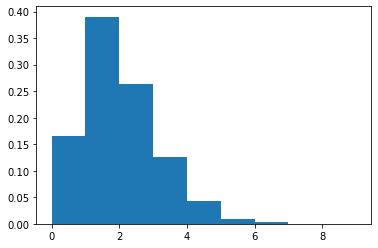

In [25]:
# TODO: Move plot_label_frequency() to core snorkel repo
import matplotlib.pyplot as plt

def plot_label_frequency(L):
    plt.hist(np.asarray((L != 0).sum(axis=1)), density=True, bins=range(L.shape[1]))    

plot_label_frequency(L_train)

We see that over half of our training dataset `DataPoints` have 0 or 1 weak labels. 
Fortunately, the signal we do have can be used to train a classifier with a larger feature set than just these labeling functions that we've created, allowing it to generalize beyond what we've specified.

## 3. Combine with Label Model

Our goal is now to convert these many weak labels into a single _noise-aware_ probabilistic (or confidence-weighted) label per `DataPoint`.
A simple baseline for doing this is to take the majority vote on a per-`DataPoint` basis: if more LFs voted SPAM than HAM, label it SPAM (and vice versa).

In [26]:
from snorkel.labeling.model import MajorityLabelVoter

mv_model = MajorityLabelVoter()
mv_model.score(L_dev, Y_dev)

{'accuracy': 0.81}

However, as we can clearly see by looking the summary statistics of our LFs, they are not all equally accurate, and should ideally not be treated identically. In addition to having varied accuracies and coverages, LFs may be correlated, resulting in certain signals being overrepresented in a majority-vote-based model. To handle these issues appropriately, we will instead use a more sophisticated Snorkel `LabelModel` to combine our weak labels.

This model will ultimately produce a single set of noise-aware training labels, which are probabilistic or confidence-weighted labels. We will then use these labels to train a classifier for our task. For more technical details of this overall approach, see our [NeurIPS 2016](https://arxiv.org/abs/1605.07723) and [AAAI 2019](https://arxiv.org/abs/1810.02840) papers.

Note that no gold labels are used during the training process; the `LabelModel` is able to estimate the accuracies of the labeling functions using only the weak label matrix as input. (See the [TODO: dependency learning](TBD) tutorial for a demonstration of how to learn correlations as well).

In [27]:
from snorkel.labeling.model import LabelModel

# TODO: get more frequent logging statement printing
label_model = LabelModel(cardinality=2, verbose=True, seed=123)
label_model.train_model(L_train, n_epochs=300, log_train_every=25)

Computing O...
Estimating \mu...
[1 epochs]: TRAIN:[loss=0.129]
[26 epochs]: TRAIN:[loss=0.022]
[51 epochs]: TRAIN:[loss=0.013]
[76 epochs]: TRAIN:[loss=0.011]
[101 epochs]: TRAIN:[loss=0.010]
[126 epochs]: TRAIN:[loss=0.009]
[151 epochs]: TRAIN:[loss=0.009]
[176 epochs]: TRAIN:[loss=0.009]
[201 epochs]: TRAIN:[loss=0.009]
[226 epochs]: TRAIN:[loss=0.009]
[251 epochs]: TRAIN:[loss=0.008]
[276 epochs]: TRAIN:[loss=0.008]
Finished Training


We can confirm that our resulting predicted labels are probabilistic, with the points we are least certain about having labels close to 0.5. The following histogram shows the confidences we have that each `DataPoint` has the label SPAM.

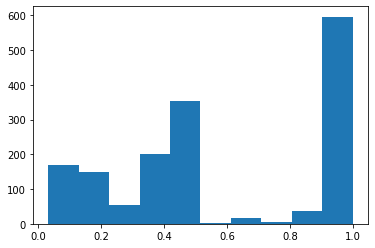

In [28]:
def plot_probabilities_histogram(Y_probs):
    plt.hist(Y_probs[:,0])
    
Y_probs_train = label_model.predict_proba(L_train)
plot_probabilities_histogram(Y_probs_train)

In [29]:
label_model.score(L_dev, Y_dev)

{'accuracy': 0.82}

While our `LabelModel` does improve over the majority vote baseline, it is still somewhat limited as a classifier. 
For example, many of our `DataPoints` have few or no LFs voting on them. 
We will now train a discriminative classifier with this training set to see if we can improve performance further.

## 4. Predict with Classifier

* Now train classifier
    * Can use any third-party classifier (plug into your existing pipelines!)
    * Some libraries natively support probabilistic labels (us, TF); for others, can round.

* Convert label convention

In [30]:
from snorkel.analysis.utils import probs_to_preds, convert_labels

# Y_train = df_train['LABEL'].map({1: 1, 2: 0}) # This will not be available
Y_train = Y_probs_train
Y_dev = convert_labels(df_dev['LABEL'].values, "categorical", "onezero")
Y_valid = convert_labels(df_valid['LABEL'].values, "categorical", "onezero")
Y_test = convert_labels(df_test['LABEL'].values, "categorical", "onezero")

* Use bag-of-ngrams as features

In [31]:
from sklearn.feature_extraction.text import CountVectorizer

words_train = [row.CONTENT for i, row in df_train.iterrows()]
words_dev = [row.CONTENT for i, row in df_dev.iterrows()]
words_valid = [row.CONTENT for i, row in df_valid.iterrows()]
words_test = [row.CONTENT for i, row in df_test.iterrows()]

vectorizer = CountVectorizer(ngram_range=(1,2))               
X_train = vectorizer.fit_transform(words_train)
X_dev = vectorizer.transform(words_dev)
X_valid = vectorizer.transform(words_valid)
X_test = vectorizer.transform(words_test)

* Filter out examples with no labels

In [32]:
mask = np.asarray(L_train.sum(axis=1) > 0).squeeze()
X_train = X_train[mask, :]
Y_train = Y_train[mask]

### Keras Classifier

* TBD

In [33]:
# TODO: 
# import simple logistic regression classifier in Keras
# train on noise-aware loss
# score
# bonus: peek at performance w/r/t using hard (int) labels i/o soft (float) labels

### Scikit-learn Classifier

* TBD
* Rounding to hard labels

In [34]:
Y_train_rounded = convert_labels(probs_to_preds(Y_train), "categorical", "onezero")

In [35]:
from sklearn.linear_model import LogisticRegression

sklearn_model = LogisticRegression()
sklearn_model.fit(X_train, Y_train_rounded)

sklearn_model.score(X_valid, Y_valid)

/Users/braden/repos/snorkel/.env/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.8378378378378378

* Compare with training on dev directly (see, we did better)
    * And we could do even better with more raw unlabeled data

In [36]:
X_dev = vectorizer.fit_transform(words_dev)
X_valid = vectorizer.transform(words_valid)
X_test = vectorizer.transform(words_test)

sklearn_model.fit(X_dev, Y_dev)
sklearn_model.score(X_valid, Y_valid)

/Users/braden/repos/snorkel/.env/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.8864864864864865

### Evaluate on Test Set

* With all ablations done, now evaluate on test

In [37]:
# TBD